# Chad Rainfall Analysis 2011

This notebook will be analysing daily rainfall in Chad for 2011 using CHIRPS satellite data. 

Due to the fact that Chad is a semi-arid climate, we identify the thresholds as:

**Drought Periods**: Days where the 7 day rolling average rainfall falls below the 10th percentile threshold.  
**Extreme Rainfall Events**: Peaks of daily rainfall above the 90th percentile threshold.

The analysis is performed first on **N'Djamena** and then extended to the **entire country**.

Below is importing the libraries required to complete this data analysis as well as loading the CHIRPS daily global rainfall for 2011 and inspect its dimensions and variables.

In [19]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


ds = xr.open_dataset("C:\Projects\geodataprojects\data\chirps_global_2011.nc")
ds

<xarray.Dataset> Size: 841MB
Dimensions:    (latitude: 400, longitude: 1440, time: 365)
Coordinates:
  * latitude   (latitude) float32 2kB -49.88 -49.62 -49.38 ... 49.38 49.62 49.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time       (time) datetime64[ns] 3kB 2011-01-01 2011-01-02 ... 2011-12-31
Data variables:
    precip     (time, latitude, longitude) float32 841MB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-10-07
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

## Subset Chad and N'Djamena

With the data of daily rainfall globally in 2011, I am going to subset **Chad** with the coordinates of 7°N to 24°N, 14°E to 24°E so that I can use the rain data for only the specific country and then select a coordinate point of 12.1°N, 15°E for **N'Djamena**. 

Due to the nature of the CHIRPS dataset, the selected values will have to be on the grid and so the coordinates have been adjusted accordingly, but still is within N'Djamena.

N’Djamena is extracted from the Chad subset to ensure spatial consistency between point-level and country-level analyses.

In [20]:
lat_min, lat_max = 7.0, 24.0
long_min, long_max = 14.0, 24.0

chad = ds.sel(
    latitude = slice(lat_min, lat_max),
    longitude = slice(long_min, long_max)
)

lat_point = chad.latitude.sel(latitude=12.125, method="nearest")
long_point = chad.longitude.sel(longitude=15.125, method="nearest")

ndjamena_rain = chad["precip"].sel(
    latitude = lat_point,
    longitude = long_point,
)

dataframe_ndjamena = ndjamena_rain.to_dataframe().reset_index()
total_days = len(dataframe_ndjamena)
dry_days = (dataframe_ndjamena["precip"] == 0).sum()
print(f"{dry_days}/{total_days} days have no rainfall ({dry_days/total_days*100:.1f}%)")

267/365 days have no rainfall (73.2%)


## Calculating Setup for the visualisation of the dataset

### 7-Day Rolling Average

To identify sustained dry or wet periods, we calculate a **7-day rolling average** of daily precipitation:

- Smooths out daily variability
- Helps detect droughts over multiple days rather than single dry days

### Drought and Extreme Rainfall Thresholds

We define thresholds to flag extreme events:

- **Drought threshold**: 10th percentile of the 7-day rolling average.  
- **Extreme rainfall threshold**: 90th percentile of daily precipitation.

These thresholds are adjusted from standard 5%/95% to account for Chad's semi-arid climate.

### Flagging Drought and Extreme Events

We create boolean columns to mark:

- **`is_drought`** → True if the 7-day rolling average is below the drought threshold  
- **`is_extreme`** → True if daily precipitation is above the extreme rainfall threshold

In [31]:
dataframe_ndjamena["rainfall_7day_avg"] = dataframe_ndjamena["precip"].rolling(7, min_periods=1).mean()

drought_threshold = dataframe_ndjamena["rainfall_7day_avg"].quantile(0.10)
dataframe_ndjamena["is_drought"] = dataframe_ndjamena["rainfall_7day_avg"] < drought_threshold

extreme_threshold = dataframe_ndjamena["precip"].quantile(0.90)
dataframe_ndjamena["is_extreme"] = dataframe_ndjamena["precip"] > extreme_threshold

## Visualizing Droughts and Extreme Rainfall

We plot a single graph combining:

- Daily rainfall (light gray)  
- 7-day rolling average (orange line)  
- Drought periods (red dots)  
- Extreme rainfall events (blue dots)  
- Threshold lines (dashed red/blue)

This helps visualize both prolonged dry periods and rare intense rainfall events.

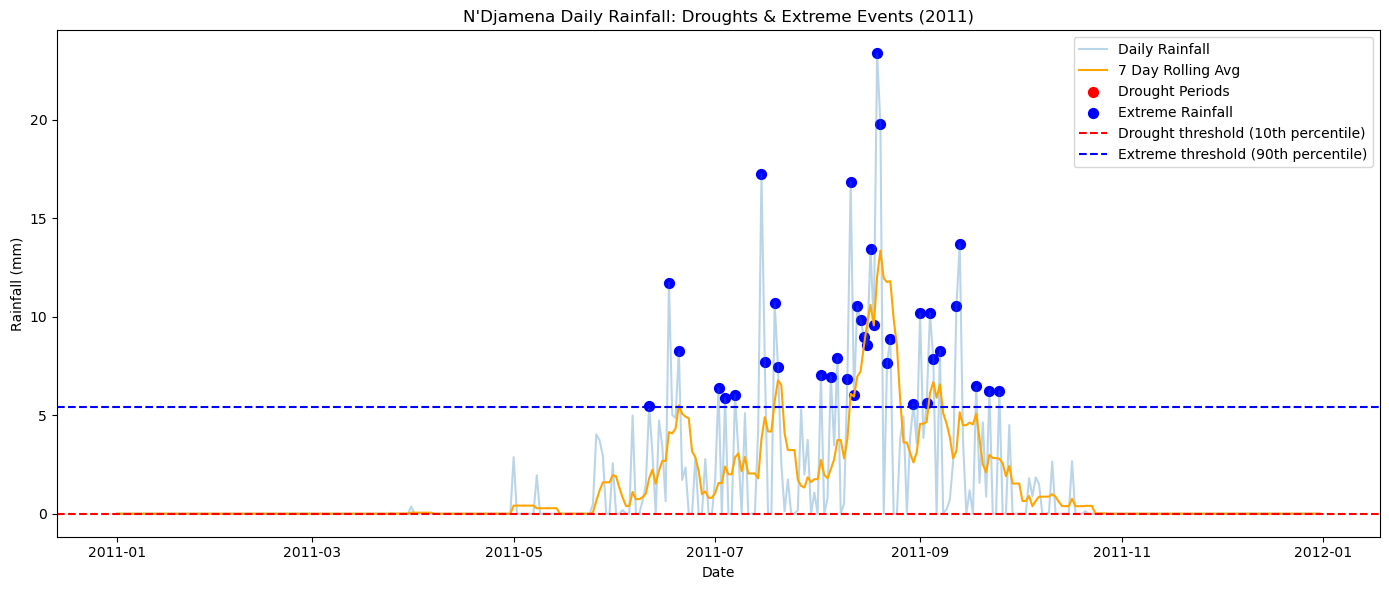

In [34]:
plt.figure(figsize=(14,6))

plt.plot(dataframe_ndjamena["time"], dataframe_ndjamena["precip"], alpha=0.3, label="Daily Rainfall")
plt.plot(dataframe_ndjamena["time"], dataframe_ndjamena["rainfall_7day_avg"], color="orange", label="7 Day Rolling Avg")

plt.scatter(
    dataframe_ndjamena.loc[dataframe_ndjamena["is_drought"], "time"],
    dataframe_ndjamena.loc[dataframe_ndjamena["is_drought"], "rainfall_7day_avg"],
    color = "red",
    label = "Drought Periods",
    s = 50
)

plt.scatter(
    dataframe_ndjamena.loc[dataframe_ndjamena["is_extreme"], "time"],
    dataframe_ndjamena.loc[dataframe_ndjamena["is_extreme"], "precip"],
    color = "blue",
    label = "Extreme Rainfall",
    s = 50
)

plt.axhline(drought_threshold, linestyle="--", color="red", label="Drought threshold (10th percentile)")
plt.axhline(extreme_threshold, linestyle="--", color="blue", label="Extreme threshold (90th percentile)")

plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.title("N'Djamena Daily Rainfall: Droughts & Extreme Events (2011)")
plt.legend()
plt.tight_layout()
plt.show()

## Summary Statistics

We calculate the number and proportion of:

- **Drought days**  
- **Extreme rainfall days**

This quantifies the frequency of these events in N'Djamena over the year 2011.

In [35]:
num_drought_days = dataframe_ndjamena["is_drought"].sum()
num_extreme_days = dataframe_ndjamena["is_extreme"].sum()
total_days = len(dataframe_ndjamena)

print(f"Drought days: {num_drought_days} ({num_drought_days/total_days*100:.1f}% of year)")
print(f"Extreme rainfall days: {num_extreme_days} ({num_extreme_days/total_days*100:.1f}% of year)")


Drought days: 0 (0.0% of year)
Extreme rainfall days: 37 (10.1% of year)


## Extending Analysis to the Entire Country

While the N'Djamena analysis illustrates the workflow for a single location, it has some limitations:

- N'Djamena is semi-arid, so most of the year has zero rainfall. Using a percentile-based method over the full year does not flag any drought days.  
- In semi-arid climates, sustained periods of 0 mm rainfall should be considered drought by default.

For the **entire country**, additional challenges arise:

- Northern Chad is desert and has almost no rainfall year-round.  
- Averaging across all grid cells would bias the analysis toward the desert climate, hiding meaningful droughts in more humid areas.

To address this, we compute **drought and extreme rainfall thresholds per grid cell**, rather than using a country-wide average. This allows us to:

- Detect droughts meaningfully across all regions, including areas that normally receive rainfall.  
- Identify extreme rainfall events relative to the local climate.  

Below, we apply this approach to the CHIRPS data for the entire country, using **7 day rolling averages per grid cell for drought detection** and **daily precipitation per grid cell for extreme rainfall events**.


In [37]:
dataframe_chad = chad.to_dataframe().reset_index()
dataframe_chad = dataframe_chad.sort_values(by=["latitude", "longitude", "time"])

dataframe_chad["rainfall_7day_avg"] = dataframe_chad.groupby(["latitude", "longitude"])["precip"].transform(lambda x: x.rolling(7, min_periods=1).mean())


## Drought and Extreme Rainfall Thresholds per gridcell

We define thresholds to flag extreme events the same as prior:

- **Drought threshold**: 10th percentile of the 7-day rolling average.  
- **Extreme rainfall threshold**: 90th percentile of daily precipitation.

### Flagging Drought and Extreme Events

We create boolean columns to mark:

- **`is_drought`** → True if the 7-day rolling average is below the drought threshold  
- **`is_extreme`** → True if daily precipitation is above the extreme rainfall threshold

In [38]:
dataframe_chad["drought_threshold"] = dataframe_chad.groupby(["latitude", "longitude"])["rainfall_7day_avg"].transform(lambda x: x.quantile(0.10))

dataframe_chad["extreme_threshold"] = dataframe_chad.groupby(["latitude", "longitude"])["precip"].transform(lambda x: x.quantile(0.90))

dataframe_chad["is_drought"] = dataframe_chad["rainfall_7day_avg"] < dataframe_chad["drought_threshold"]
dataframe_chad["is_extreme"] = dataframe_chad["precip"] > dataframe_chad["extreme_threshold"]